In [8]:
# !python -m pip install matplotlib==2.2.3
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
import copy
class Slot():

    def __init__(self, word, is_core, page_destination):

        # word = str que l'on souhaite traiter et placer sur la grille
        # is Core = Booléen un indiquant si le mot traité fait parti du vocabulaire core ou non
        self.__word = copy.copy(word)
        self.__is_core = copy.copy(is_core)
        self.__page_destination = copy.copy(page_destination)

    # Accesseur
    def get_word(self):

        return self.__word

    # Accesseur
    def get_is_core(self):

        return self.__is_core

    def get_page_destination(self):

        return self.__page_destination

    def __str__(self):

        dest = self.__page_destination
        if dest != None:
            dest = self.__page_destination.get_name()
        return '('+str(self.__word) + ';' + str(self.__is_core) + ';' + str(dest) + ')'



In [11]:
class Page():

  #Constructor
    def __init__(self, name, row_size, col_size):

        self.__name = name
        self.__row_size = row_size
        self.__col_size = col_size
        self.__full = False
        self.__slots = []
        self.__fill()
        self.__last_R = 0
        self.__last_C = 0

    #Initialise chacun des slots à None
    def __fill(self):

      self.__slots = []
      for i in range(0, self.__row_size) :
        self.__slots.append([None])
        for j in range(0, self.__col_size) :
          self.__slots[i].append(None)

    # Ajoute le Slot slot en position num_row, num_col et renvoie l'ancienne valeur
    def set_slot(self, slot, num_row, num_col):

      if (num_row >= self.__row_size) or (num_col >= self.__col_size):
        raise Exception('Error: slot row or col out of bounds') 
      old_value = self.__slots[num_row][num_col]
      self.__slots[num_row][num_col]=slot
      return old_value

    def set_name(self, name):
      self.__name = name
      return name

    # Accessors
    def get_name(self):

      return self.__name

    def get_slot(self, num_row, num_col):

      return self.__slots[num_row][num_col]

    def get_slot_list(self):

      return self.__slots

    #Return true if the slot at position (num_row, num_col) is free, false otherwise
    def is_free(self, num_row, num_col):

      return self.__slots[num_row][num_col] == None

    #Return true if table is full, false otherwise
    def is_full(self):
      if (self.__full):
        return True
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          if self.__slots[row][col] == None:
            return False
      self.__full = True
      return True

    def add_word(self, word, core=False, dest=None) :

      if(self.__last_C == self.__col_size) : 
        self.__last_C = 0
        self.__last_R += 1
      if(self.__last_R == self.__row_size) :
        self.__full = True
        print("Failed to add word <", word, ">. The table is full.")
        return None

      if(self.__slots[self.__last_R][self.__last_C] == None) :

        s = Slot(word, core, dest)
        self.__slots[self.__last_R][self.__last_C] = s
        self.__last_R
        self.__last_C += 1
        return word
      
      self.__last_R
      self.__last_C += 1
      return self.add_word(word)

    # Méthode d'affichage (à revoir ? Efficacité chaînes de caractères)
    def __str__(self):

      s = "Page: " + self.__name + "\n("
      for i in range(0, self.__row_size) : 
        for j in range(0, self.__col_size) :
          s+=str(self.__slots[i][j])
          s+=", "
        s+='\n'
      return s+')'

    # def show(self):

    #   from ipywidgets import GridspecLayout

    #   grid = GridspecLayout(self.__row_size, self.__col_size, width='50%')

    #   for i in range(self.__row_size):
    #     for j in range(self.__col_size):
    #       # grid[i, j] = create_expanded_button('Button {} - {}'.format(i, j), 'success')
    #       grid[i, j] = create_expanded_button(str(self.__slots[i][j]), 'success')

    #   return grid



In [21]:
class Grid():

  #Constructor
  def __init__(self, row_size, col_size, core_voc):

    self.__row_size = row_size
    self.__col_size = col_size
    self.__core_voc = core_voc
    self.__pages = []
    self.__pageCounter = 0
    self.__add_page2()   

  #ToDo
  def add_word(word):

    return

  def __get_last_page(self):

    return self.__pages[-1]

  # We assume that the word has not been already added
  def add_word(self, word):

    if self.__pages[-1].is_full() :

      self.__add_page2()

    self.__pages[-1].add_word(word)

    return

  def __add_page2(self):

    # self.__add_page(str(self.__pageCounter))
    page = self.__add_page('accueil')
    self.__add_core_voc(page)    

  def __add_page(self, name_page):

    page = Page(name_page, self.__row_size, self.__col_size)    
    self.__pages.append(page)
    self.__pageCounter += 1 

    return page

  def __add_core_voc(self, page):

    for item in self.__core_voc:
      
      s = Slot(item[0], True, None)     #fix None by default
      num_row = item[1]
      num_col = item[2]
      page.set_slot(s, num_row, num_col)

  def add_new_page(self, name):

    return self.__add_page(name)

  #ToDo
  def to_graph(self):

    nodes = set([])
    edges = set([])
    for page in self.__pages:
      name = page.get_name()
      nodes.add(name)
      slots = page.get_slot_list()
      for items in slots:
        for slot in items:
          if slot != None:
            dest = slot.get_page_destination()
            if dest != None:
              dest = dest.get_name()
              edges.add((name, dest))
    
    G=nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw(G,with_labels=True)
    # plt.savefig("simple_path.png") # save as png
    plt.show() # display

    return G

  #ToDo
  def fusion_with(self, grid):

    return

  def get_nb_pages(self):

    return self.__pageCounter
  
  def get_page_names(self):
    pages = []
    for page in self.__pages:
      name = page.get_name()
      pages.append(name)
      print(name, end=' ')
    print()
    return pages

  def get_page(self, name):
    for page in self.__pages:
      if page.get_name() == name:
        return page
    raise Exception('Page not found') 

  # Méthode d'affichage 1
  def __str__(self):

    s = 'grid : {\n'
    for i in range(0, len(self.__pages)):
      s+= str(self.__pages[i]) + '\n'
    s += '}\n'
    return s

  # Méthode d'affichage 2
  # def display(self):
  #   g = []
  #   for i in range(len(self.__pages)):
  #     g.append(self.__pages[i].show())
    
  #   return g

# TESTING

grid : {
Page: accueil
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), None, 
)
Page: page2
((hello;False;None), None, None, 
None, None, None, 
)
Page: page3
((HI;False;page2), (world;False;accueil), None, 
None, None, None, 
)
}



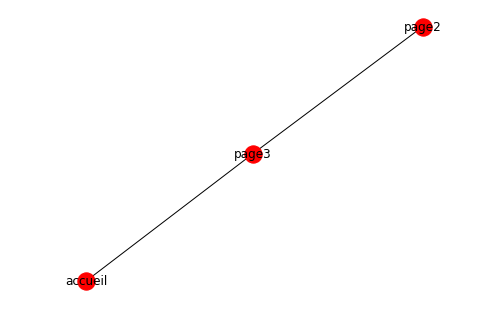

In [25]:
c_v = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0], ["h", 0, 2]]
g = Grid(2,3, c_v)
np2 = g.add_new_page('page2')
np2.add_word('hello')
# print(g)
np3 = g.add_new_page('page3')
np3.add_word('HI', False, np2)
np3.add_word('world', False, g.get_page('accueil'))
print(g)
g.to_graph()

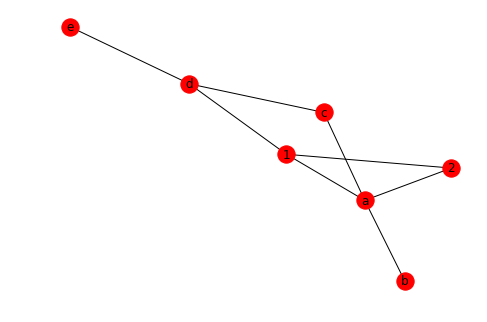

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


G=nx.Graph()
G.add_node("a")
G.add_nodes_from(["b","c"])

G.add_edge(1,2)
edge = ("d", "e")
G.add_edge(*edge)
edge = ("a", "b")
G.add_edge(*edge)
# adding a list of edges:
G.add_edges_from([("a","c"),("c","d"), ("a",1), (1,"d"), ("a",2)])

nx.draw(G,with_labels=True)
# plt.savefig("simple_path.png") # save as png
plt.show() # display

In [141]:
from ipywidgets import GridspecLayout
def show():
    l = []  
    for a in range(2, 4):
      grid = GridspecLayout(a, a, width='50%')

      for i in range(a):
        for j in range(a):
          grid[i, j] = create_expanded_button('Button {} - {}'.format(i, j), 'success')
        #   grid[i, j] = create_expanded_button(str(self.__slots[i][j]), 'success')
      l.append(grid)
    return l

# b = show()
# b[0]


In [91]:
c_v = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0], ["h",0,2]]
g = Grid(2,3, c_v)
print(g)
g.add_new_page('page2')
print(g)



grid : {
Page: 0
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), None, 
)
}

grid : {
Page: 0
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), None, 
)
Page: page2
(None, None, None, 
None, None, None, 
)
}



In [29]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

# top_left_button = create_expanded_button("Top left", 'info')
# top_right_button = create_expanded_button("Top right", 'success')
# bottom_left_button = create_expanded_button("Bottom left", 'danger')
# bottom_right_button = create_expanded_button("Bottom right", 'warning')

# top_left_text = IntText(description='Top left', layout=Layout(width='auto', height='auto'))
# top_right_text = IntText(description='Top right', layout=Layout(width='auto', height='auto'))
# bottom_left_slider = IntSlider(description='Bottom left', layout=Layout(width='auto', height='auto'))
# bottom_right_slider = IntSlider(description='Bottom right', layout=Layout(width='auto', height='auto'))

GridspecLayout(children=(Button(button_style='success', description='Button 0 - 0', layout=Layout(grid_area='w…

In [3]:
p = Page("animaux", 2, 2)
print(p)
print(p.is_full())
print(p.add_word("chat"))
print(p)
print(p.is_full())
print(p.add_word("chien"))
print(p)
print(p.is_full())
print(p.add_word("cheval"))
print(p)
print(p.is_full())
print(p.add_word("oiseau"))
print(p)
print(p.is_full())
print(p.add_word("dromadaire"))
print(p)
print(p.is_full())
print(p.add_word("chameau"))
print(p)
print(p.is_full())


Page: animaux
(None, None, 
None, None, 
)
False
chat
Page: animaux
((chat;False;None), None, 
None, None, 
)
False
chien
Page: animaux
((chat;False;None), (chien;False;None), 
None, None, 
)
False
cheval
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), None, 
)
False
oiseau
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True
Failed to add word < dromadaire >. The table is full.
None
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True
Failed to add word < chameau >. The table is full.
None
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True


In [4]:
s = Slot("chien", True, "")
s2 = Slot("chat", False, "")
p = Page("animaux",3,4)
print(p.get_slot(1,2))
print(p.set_slot(s, 1,2))
print(p.get_slot(1,2))
print(p.set_slot(s, 1,2))
print(p.get_slot(1,2))
print(p.set_slot(s2, 1,2))
print(p.get_slot(1,2))
print(p)
print(p.get_name())
p.set_name("véhicules")
print(p)
print(p.get_name())
print(p.is_free(1,2))
print(p.is_free(2,2))
print(p.is_full())



None
None
(chien;True;)
(chien;True;)
(chien;True;)
(chien;True;)
(chat;False;)
Page: animaux
(None, None, None, None, 
None, None, (chat;False;), None, 
None, None, None, None, 
)
animaux
Page: véhicules
(None, None, None, None, 
None, None, (chat;False;), None, 
None, None, None, None, 
)
véhicules
False
True
False


In [7]:
# TESTING
# g = Grid(3,4, [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0]])
# print(g)
# g.add_word("chien")
# print(g)
# g.add_word("chien")
# print(g)
# g.add_word("chien")
# print(g)
# g.get_number_pages()
